#  Masking Pipeline


"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

## NSLS2 data retrieval imports

In [37]:
from databroker import DataBroker as db, get_images, get_table, get_events
from filestore.api import register_handler, deregister_handler
from filestore.retrieve import _h_registry, _HANDLER_CACHE

In [38]:
hdr = db[{{ uid }}]

TypeError: unhashable type: 'set'

In [39]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

%matplotlib notebook

## Lazy Eiger Handler (later will goto databroker)¶

In [40]:
import h5py
from filestore.retrieve import HandlerBase
from eiger_io.pims_reader import EigerImages

EIGER_MD_DICT = {
    'y_pixel_size': 'entry/instrument/detector/y_pixel_size',
    'x_pixel_size': 'entry/instrument/detector/x_pixel_size',
    'detector_distance': 'entry/instrument/detector/detector_distance',
    'incident_wavelength': 'entry/instrument/beam/incident_wavelength',
    'frame_time': 'entry/instrument/detector/frame_time',
    'beam_center_x': 'entry/instrument/detector/beam_center_x',
    'beam_center_y': 'entry/instrument/detector/beam_center_y',
    'count_time': 'entry/instrument/detector/count_time',
    'pixel_mask': 'entry/instrument/detector/detectorSpecific/pixel_mask',
}

class FixedEigerImages(EigerImages):
    def __init__(self, path, metadata):
        super().__init__(path)
        self._metadata = metadata
    
    @property
    def md(self):
        return self._metadata
    
    @property
    def dtype(self):
        return self.pixel_type
    
    @property
    def shape(self):
        return self.frame_shape

class LazyEigerHandler(HandlerBase):
    specs = {'AD_EIGER'} | HandlerBase.specs
    def __init__(self, fpath, frame_per_point, mapping=None):
        # create pims handler
        self.vals_dict = EIGER_MD_DICT.copy()
        if mapping is not None:
            self.vals_dict.update(mapping)
        self._base_path = fpath
        self.fpp = frame_per_point

    def __call__(self, seq_id):
        import h5py
        master_path = '{}_{}_master.h5'.format(self._base_path, seq_id)
        md = {}
        print('hdf5 path = %s' % master_path)
        with h5py.File(master_path, 'r') as f:
            md = {k: f[v].value for k, v in self.vals_dict.items()}
        # the pixel mask from the eiger contains:
        # 1  -- gap
        # 2  -- dead
        # 4  -- under-responsive
        # 8  -- over-responsive
        # 16 -- noisy
        pixel_mask = md['pixel_mask']
        pixel_mask[pixel_mask>0] = 1
        pixel_mask[pixel_mask==0] = 2
        pixel_mask[pixel_mask==1] = 0
        pixel_mask[pixel_mask==2] = 1
        md['framerate'] = 1./md['frame_time']
        # TODO Return a multi-dimensional PIMS seq
        return FixedEigerImages(master_path, md)

deregister_handler('AD_EIGER')
_HANDLER_CACHE.clear()
register_handler('AD_EIGER', LazyEigerHandler)

In [41]:
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("    %s: %s" % (key, val))


In [43]:
uid = '528bd8'

hdr = db[uid]

## Get the data from the uid or scan id

In [44]:
ev, = get_events(hdr, ['eiger_4M_cam_img_image_lightfield'])

hdf5 path = /XF11ID/data/2015/11/5/794b68e2-ebc7-4aa8-a3e4_422_master.h5


In [45]:
from datetime import datetime
dt = datetime.fromtimestamp(hdr['start'].time)
path ='/XF11ID/analysis' + '/%s/%s/%s/' % (dt.year, dt.month, dt.day)
path

'/XF11ID/analysis/2015/11/5/'

In [46]:
imgs = ev['data']['eiger_4M_cam_img_image_lightfield']
print (imgs)
Nimg=len(imgs)

<Frames>
Length: 1 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint32


## show the pixel mask

<IPython.core.display.Javascript object>


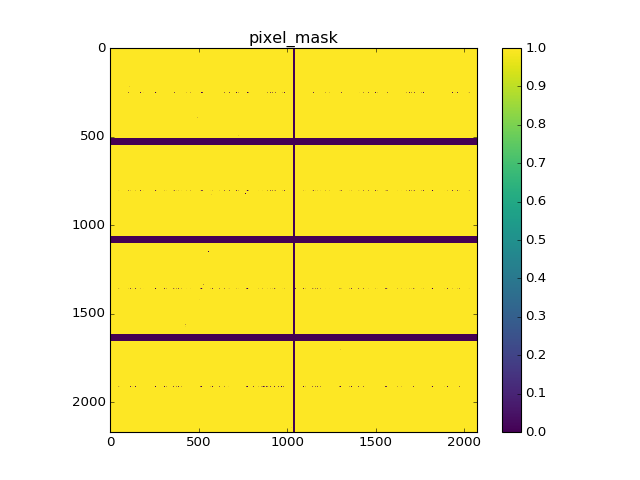

In [47]:
fig, ax = plt.subplots()
im = ax.imshow(imgs.md['pixel_mask'], vmin=0,vmax=1,cmap='viridis')
ax.set_title( 'pixel_mask')
fig.colorbar( im )
plt.show()

## Import all the required packages to create manual mask
xray-vision - plotting helper functions for X-ray science
https://github.com/Nikea/xray-vision

In [48]:
import xray_vision
import xray_vision.mpl_plotting as mpl_plot  
from xray_vision.mpl_plotting import speckle
from xray_vision.mask.manual_mask import ManualMask

## Remove hotspots in the image

In [49]:
class RemoveHotSpots(object):
    def __init__(self, indexable, threshold= 1E7 ):
        self.indexable = indexable
        self.threshold = threshold
        self.N = len( indexable  ) 
    def _get_mask(self ):
        mask = np.ones_like( np.array( self.indexable[0])    )
        for key in range(self.N):
            data = np.array( self.indexable[key])  #.copy()        
            badp = np.where(  data >= self.threshold )
            if len(badp[0])!=0:                
                mask[badp] = 0                            
        return mask

### Enter the therdshold to remove the hotspots

In [50]:
mask_rh  = RemoveHotSpots(imgs, 5E4)._get_mask()

In [51]:
mask_rh.shape

(2167, 2070)

## Get the Averaged Image Data

In [52]:
avg_img = np.average(imgs[::50], axis=0) *imgs.md['pixel_mask']*mask_rh

In [53]:
avg_img.shape

(2167, 2070)

<IPython.core.display.Javascript object>


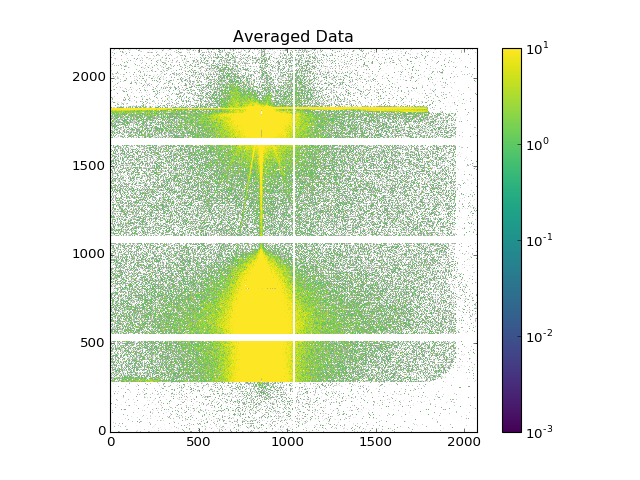

In [54]:
# Plot the result
fig, ax = plt.subplots()
im = ax.imshow(avg_img,  cmap='viridis',origin='lower',
               norm= LogNorm( vmin=0.001, vmax=1e1 ) )

fig.colorbar(im)
ax.set_title("Averaged Data")
plt.show()

## Create the mask file
More information : https://github.com/Nikea/xray-vision/blob/master/xray_vision/mask/manual_mask.py

<IPython.core.display.Javascript object>


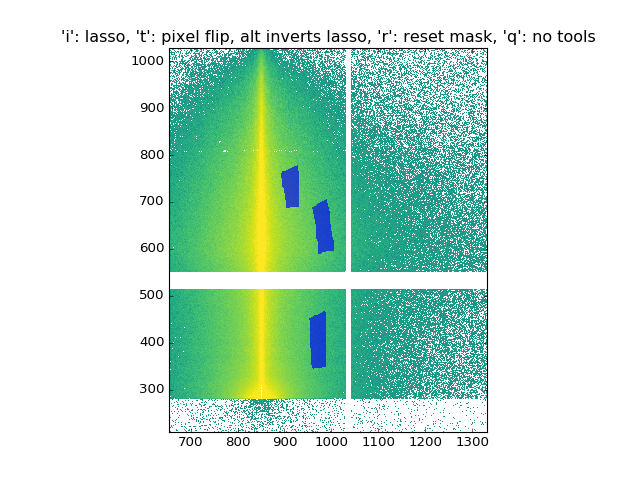

In [91]:
fig, ax = plt.subplots()
m = ManualMask(ax, avg_img*imgs.md['pixel_mask']*mask_rh,
               cmap='viridis',origin='lower',
               norm= LogNorm( vmin=0.001, vmax=1e3 ) )
#press o to quit zoom mode

plt.show()

<IPython.core.display.Javascript object>


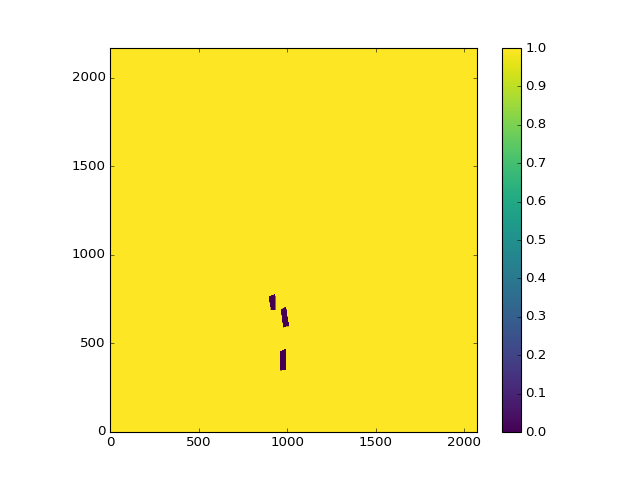

In [92]:
new_mask = m.mask
fig, ax = plt.subplots()
im=ax.imshow(~new_mask, origin='lower', vmin=0, vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

In [64]:
np.where( m.label_array ==5)

(array([581, 582, 582, ..., 750, 750, 750]),
 array([ 989,  988,  989, ..., 1006, 1007, 1008]))

In [59]:
m.mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [93]:
np.unique( m.label_array)

array([0, 1, 2, 3], dtype=int32)

In [100]:
x = np.zeros_like( m.label_array)

In [101]:
x[ np.where( m.label_array == 3) ] =5

In [149]:
new_mask =  x
fig, ax = plt.subplots()
im=ax.imshow(new_mask, origin='lower', vmin=0, vmax=5,cmap='viridis')
fig.colorbar(im)
plt.show()

<IPython.core.display.Javascript object>

TypeError: Invalid dimensions for image data

In [108]:
regions  = m.label_array
np.unique( regions)

array([0, 1, 2, 3], dtype=int32)

In [106]:
noqs = len(  np.unique( regions ))
noqs

4

In [104]:
import sys, shutil
EssCod_PATH='/home/yuzhang/XPCS_Anlysis/notebook_XPCS/EssCode/'
EssCod_PATH in sys.path or sys.path.append(EssCod_PATH)
 

from Get_Data import readframe_series
from Process_Data import average_img, cpdump,cpopen 
from Plot_Data import plot,show_img,show_mask,show_img_with_ROI,pd_data_plot,show_grid_img,plot_with_fit
from XPCS_Functions import make_qlist, calqlist,get_trace_and_maxc
from XPCS_Functions import get_pixellist_intensity,azimuthal_integration
from XPCS_Functions import calqlist_regions, get_waterfall,get_Iq_waterfall,fit_g2
from XPCS import xpcs

from XSVS import xsvs
from Plot_XSVS import xsvs_plot_histogram


import numpy as np
import matplotlib.pyplot as plt

In [182]:
def get_photo_statis( img, regions ):
    noqs = len(  np.unique( regions )) -1
    qHist=[1] * noqs
    qBins =[1] * noqs

    for j in range(1, noqs +1 ):       
        intenj = np.where( regions == j) 
        data = img[ intenj ]   
        maxcts = data.max()
        BinEdges = np.arange( maxcts )
        qHist[j-1],qBins[j-1] = np.histogram(data,bins= BinEdges,normed = True) 
    return qHist, qBins
    

In [122]:
from scipy import stats
from scipy.special import gamma, gammaln

def gamma_dist(bin_values, K, M):
    """
    Gamma distribution function
    Parameters
    ----------
    bin_values : array
        scattering intensities
    K : int
        number of photons
    M : int
        number of coherent modes
    Returns
    -------
    gamma_dist : array
        Gamma distribution
    Notes
    -----
    These implementations are based on the references under
    nbinom_distribution() function Notes

    : math ::
        P(K) =(\frac{M}{<K>})^M \frac{K^(M-1)}{\Gamma(M)}\exp(-M\frac{K}{<K>})
    """

    gamma_dist = (stats.gamma(M, 0., K/M)).pdf(bin_values)
    return gamma_dist


def nbinom_dist(bin_values, K, M):
    """
    Negative Binomial (Poisson-Gamma) distribution function
    Parameters
    ----------
    bin_values : array
        scattering bin_values
    K : int
        number of photons
    M : int
        number of coherent modes
    Returns
    -------
    nbinom : array
        Negative Binomial (Poisson-Gamma) distribution function
    Notes
    -----
    The negative-binomial distribution function
    :math ::
        P(K) = \frac{\\Gamma(K + M)} {\\Gamma(K + 1) ||Gamma(M)}(\frac {M} {M + <K>})^M (\frac {<K>}{M + <K>})^K

    These implementation is based on following references

    References: text [1]_
    .. [1] L. Li, P. Kwasniewski, D. Oris, L Wiegart, L. Cristofolini,
       C. Carona and A. Fluerasu , "Photon statistics and speckle visibility
       spectroscopy with partially coherent x-rays" J. Synchrotron Rad.,
       vol 21, p 1288-1295, 2014.

    """
    co_eff = np.exp(gammaln(bin_values + M) -
                    gammaln(bin_values + 1) - gammaln(M))

    nbinom = co_eff * np.power(M / (K + M), M) * np.power(K / (M + K),
                                                          bin_values)
    return nbinom


def poisson_dist(bin_values, K):
    """
    Poisson Distribution
    Parameters
    ---------
    K : int
        number of photons
    bin_values : array
        scattering bin_values
    Returns
    -------
    poisson_dist : array
       Poisson Distribution
    Notes
    -----
    These implementations are based on the references under
    nbinom_distribution() function Notes
    :math ::
        P(K) = \frac{<K>^K}{K!}\exp(-K)
    """
    #poisson_dist = stats.poisson.pmf(K, bin_values)
    poisson_dist = np.exp(-K) * np.power(K, bin_values)/gamma(bin_values + 1)
    return poisson_dist

In [183]:
from lmfit import  Model

g_mod = Model(gamma_dist)
n_mod = Model(nbinom_dist)
p_mod = Model(poisson_dist)

In [ ]:
y,x = qHist[0], qBins[0][:-1]
result_n = n_mod.fit(y,bin_values=x, K=5, M=10)
print (result_n.best_values)
fig,ax=plt.subplots()
ax.plot(x,y, 'ro')
ax.plot( x, result_n.best_fit, '-b')
#plt.xlim(0, 1.5)
plt.show()

In [184]:
qHist, qBins = get_photo_statis( imgs[0], regions )

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [185]:
len(qBins)

3

In [186]:
def fit_photo_statis( qHist, qBins ):
    noqs = len(  qHist )

    for j in range(0, noqs ): 
        print (j)
        y,x = qHist[j], qBins[j][:-1]
        result_n = n_mod.fit(y,bin_values=x, K=5, M=10)
        print (result_n.best_values)
        fig,ax=plt.subplots(1,3)
        ax[0].plot(x,y, 'ro')
        ax[0].plot( x, result_n.best_fit, '-b')
        #plt.xlim(0, 1.5)
        plt.show()
 
 

0
{'M': 17.984453828246167, 'K': 16.354998477472627}


<IPython.core.display.Javascript object>


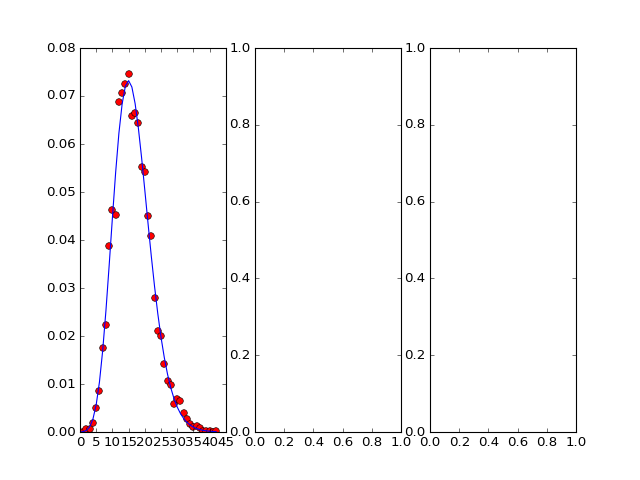

1
{'M': 10.788329313325981, 'K': 22.145269433488053}


<IPython.core.display.Javascript object>


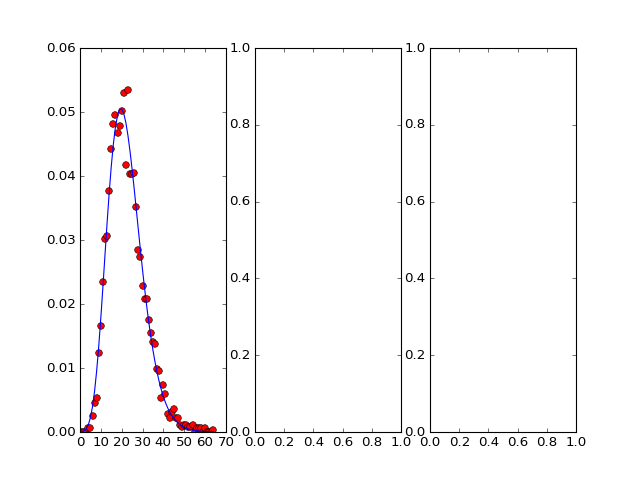

2
{'M': 9.2900917826049287, 'K': 55.828433698911411}


<IPython.core.display.Javascript object>


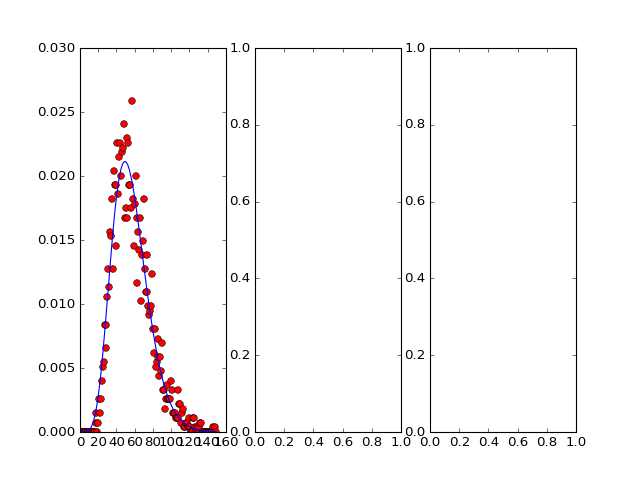

In [187]:
fit_photo_statis( qHist, qBins)

In [152]:
y,x = qHist[0], qBins[0][:-1]

In [153]:
#fig,ax=plt.subplots()
#ax.plot(x,y, 'ro')

In [154]:
y

array([ 0.        ,  0.        ,  0.00053135,  0.00053135,  0.00185972,
        0.00504782,  0.00850159,  0.01753454,  0.02231668,  0.03878852,
        0.04622742,  0.04516472,  0.06880978,  0.0706695 ,  0.07252922,
        0.07465462,  0.06588735,  0.0664187 ,  0.0642933 ,  0.05526036,
        0.05419766,  0.04489904,  0.04091392,  0.02789586,  0.02098831,
        0.01992561,  0.01408077,  0.01062699,  0.00982997,  0.00584485,
        0.00690755,  0.0063762 ,  0.00398512,  0.00265675,  0.00159405,
        0.0010627 ,  0.00132837,  0.00079702,  0.00026567,  0.00026567,
        0.00026567,  0.        ,  0.00026567])

In [159]:
x.shape

(43,)

In [158]:
y.shape

(43,)

{'M': 17.984453828246167, 'K': 16.354998477472627}


<IPython.core.display.Javascript object>


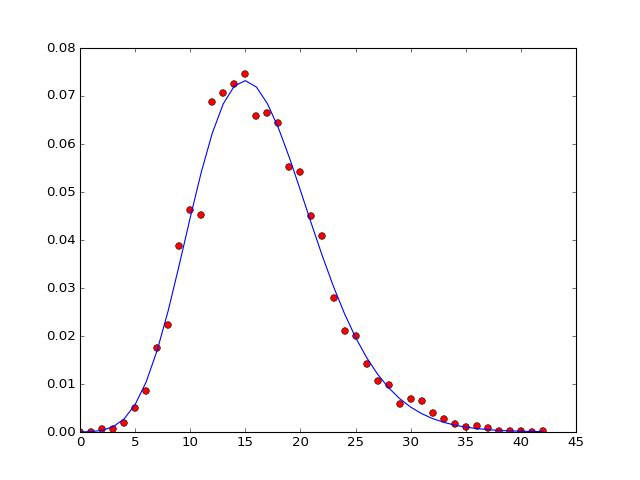

In [171]:
y,x = qHist[0], qBins[0][:-1]
result_n = n_mod.fit(y,bin_values=x, K=5, M=10)
print (result_n.best_values)
fig,ax=plt.subplots()
ax.plot(x,y, 'ro')
ax.plot( x, result_n.best_fit, '-b')
#plt.xlim(0, 1.5)
plt.show()

<IPython.core.display.Javascript object>


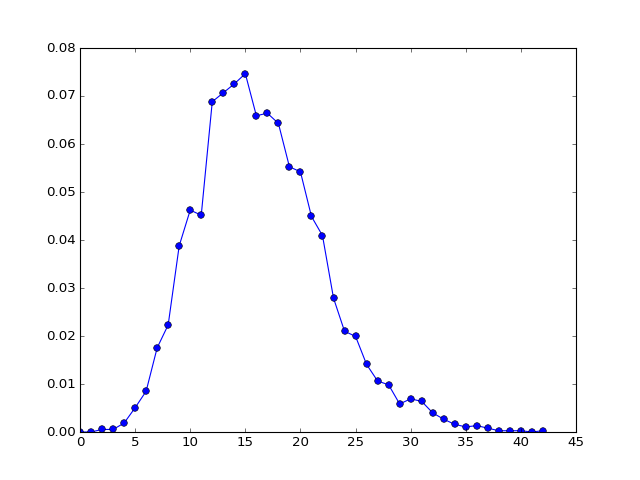

In [147]:
fig,ax=plt.subplots()
ax.plot( qBins[0][:-1], qHist[0] ,'bo', ls='-' )

<IPython.core.display.Javascript object>


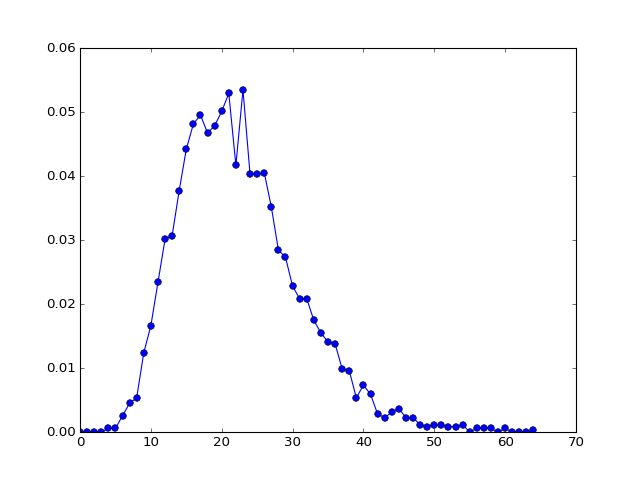

In [148]:
fig,ax=plt.subplots()
ax.plot( qBins[1][:-1], qHist[1] ,'bo', ls='-' )

<IPython.core.display.Javascript object>


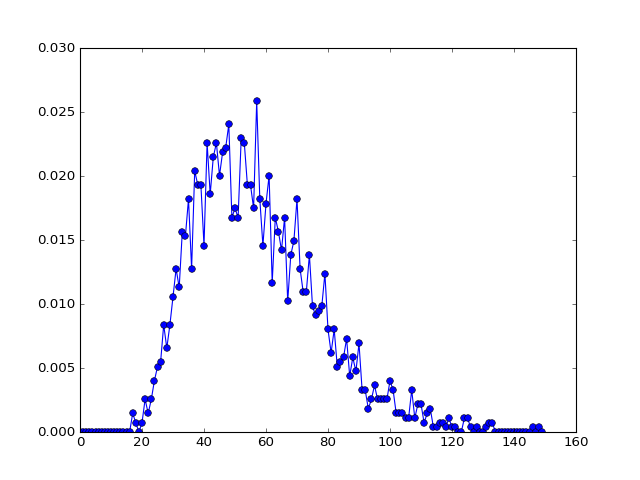

In [121]:
fig,ax=plt.subplots()
ax.plot( qBins[2][:-1], qHist[2] ,'bo', ls='-' )

In [116]:
qBins[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43])

In [ ]:
ig = np.random( 100,150)
fig, ax = plt.subplots()
m = ManualMask(ax, ig,
               cmap='viridis',origin='lower',
               norm= LogNorm( vmin=0.001, vmax=1e1 ) )
plt.show()

## Combine the hand-drawn mask and the pixel mask and hot pixel mask

In [ ]:
mask = (~new_mask)*imgs.md['pixel_mask']*mask_rh

fig, ax = plt.subplots()
im = ax.imshow(mask, origin='lower', vmin=0, vmax=1, cmap='viridis')
fig.colorbar(im)
plt.show()

## save the combined mask to use in data analysis

In [ ]:
np.save(path +  str(uid)+"_mask", mask)